# Machine Learning Regression

Regression is a fundamental technique in machine learning used for predicting continuous outcomes. It's widely used in various domains, such as finance, healthcare, and economics, to forecast trends, analyze relationships, and make predictions based on input variables.


In [ ]:
# download the data
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [1]:
# import all the necessary libraries
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

## Prepare the data and Exploratory Data Analysis (EDA):

In [2]:
df = pd.read_csv('housing.csv', iterator=False)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Get only the records with where ocean_proximity is either '<1H OCEAN' or 'INLAND'

In [3]:
# get the records where ocean_proximity is '<1H OCEAN' or 'INLAND' 
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [4]:
# from the data frame select only these features:
features = ['latitude', 'longitude', 'housing_median_age','total_rooms','total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
df = df[features]
df.head()


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


### Question 1 - Find the feature with missing values

In [5]:
# find the feature with missing values
df_missing_data = df.isnull().sum()
df_missing_data.head(9)

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2 - What's the median (50% percentile) for variable 'population'?

In [6]:
# get the median for population
median_population = df['population'].median()
median_population

1195.0

In [7]:
# shuffle the dataset with the seed 42
df_sample = df.sample(frac=1, random_state=42)

# split the dataset into parts: train (60%) validate (20%) and test (20%)
df_train = (df_sample.iloc[:int(len(df_sample)*0.6)]).reset_index(drop=True)
df_validate = (df_sample.iloc[int(len(df_sample)*0.6):int(len(df_sample)*0.8)]).reset_index(drop=True)
df_test = (df_sample.iloc[int(len(df_sample)*0.8):]).reset_index(drop=True)

# check the size of each part matches the expected
total_len = len(df_sample)
train_len = len(df_train)
validate_len = len(df_validate)
test_len = len(df_test)
print(f"Total: {total_len} Train: {train_len} Validate: {validate_len} Test: {test_len}")
print(f"Compare the sets: {total_len} = {train_len + validate_len + test_len}")


Total: 15687 Train: 9412 Validate: 3137 Test: 3138
Compare the sets: 15687 = 15687


In [8]:
# Apply the log transformation to the median_house_value variable using the np.log1p() function
base_feature = ['median_house_value']
y_train = np.log1p(df_train[base_feature])
y_validate = np.log1p(df_validate[base_feature])
y_test = np.log1p(df_test[base_feature])
y_train.head()

,median_house_value
0,11.161963
1,12.321635
2,12.471896
3,12.359227
4,12.574531


In [9]:
# define hte function to calculate the root mean squared error, use the regularized linear regression when provided with the parameter r
def train_linear_regression(X, y, r=None):
    """
    This function takes the input feature matrix X and target variable y, calculates the optimal weights 
    for the linear regression model using the Ordinary Least Square (OLS) method, and returns the intercept and weights for the model.
    Use the regularized linear regression when provided with the parameter r
    """

    # add 1s to the feature matrix X to consider the bias term (intercept) in the linear regression
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)

    # add the regularization term to the diagonal of the XTX matrix when r is provided
    if r is not None:
        XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [10]:
# prepare the data for the model, fill base features na with 0
def prepare_X(df, base_feature, fillna_value=0):
    """
    This function takes the input data frame df and the list of features base_feature,
    fills the missing values with fillna_value, and returns the feature matrix X.
    """
    X = df[base_feature].fillna(fillna_value).values    
    return X


In [11]:
def get_the_model_prediction(df, base_feature, y, fillna_value):
    """
    This function takes the input data frame df, the base_feature, and the target variable y, 
    calculates the optimal weights for the linear regression model using the Ordinary Least Square (OLS) method, 
    and returns the predictions for the target variable y.
    """

    # fill in the missing values with the median value from the train set
    X_train = df[base_feature].fillna(fillna_value).values

    # train the linear regression model on the train set and the intercept and weights for the model
    w0, w = train_linear_regression(X_train, y)

    # get the predictions for the train set 
    y_pred = w0 + X_train.dot(w)
    y_pred
    
    return y_pred

Prediction with 0: [[11.41536817]
 [12.17096883]
 [12.34944945]]
Prediction with median: [[11.41536817]
 [12.17096883]
 [12.34944945]]


<Axes: xlabel='median_house_value', ylabel='Count'>

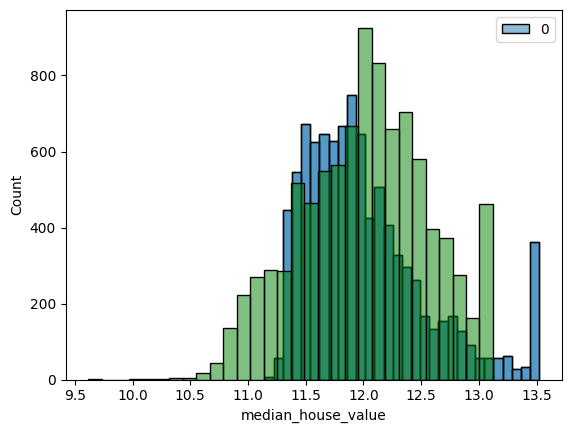

In [12]:
# on the train set, fill the missing values with 0 and calculate the predictions
y_pred_with_zero = get_the_model_prediction(df_train, base_feature, y_train, 0)

# on the train set, fill the missing values with the median value from the train set and calculate the predictions
y_pred_with_median = get_the_model_prediction(df_train, base_feature, y_train, y_train.median().values[0])

# print the prediction results
print(f"Prediction with 0: {y_pred_with_zero[:3]}")
print(f"Prediction with median: {y_pred_with_median[:3]}")

# use sns.histplot to compare the distribution of the target variable y_train and the predictions y_train_pred_with_zero and y_train_pred_with_median
sns.histplot(y_pred_with_zero, color='red', alpha=0.5, bins=30)
sns.histplot(y_pred_with_median, color='blue', alpha=0.5, bins=30)
sns.histplot(y_train['median_house_value'], color='green', alpha=0.5, bins=30)


In [13]:
# define the rmse function
def rmse(y, y_pred):
    """
    This function takes the target variable y and the predictions y_pred, calculates the root mean squared error, and returns the rmse value.
    """
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

### Question 3 - Which option provides the best RMSE?

In [14]:
# use the validation set to evaluate the predicted models y_pred_with_zero, y_pred_with_median 
# and compare the rmse values and round to 2 decimal places
rmse_with_zero = round(rmse(y_train, y_pred_with_zero),2)[0]
rmse_with_median = round(rmse(y_train, y_pred_with_median),2)[0] 
print(f"RMSE with 0: {rmse_with_zero}")
print(f"RMSE with median: {rmse_with_median}")
result = rmse_with_zero - rmse_with_median
label = "the same" if result == 0 else "better with zero" if result < 0 else "better with mean"
print(f"RMSE is {label}")

RMSE with 0: 0.18
RMSE with median: 0.18
RMSE is the same


### Question 4 - regularized linear regression which r results in best rmse

In [16]:
# List of regularization parameters (r)
r_values = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

# prepare the data for the model, fill base features na with 0
X_train = prepare_X(df_train, base_feature, fillna_value=0)
X_validate = prepare_X(df_validate, base_feature, fillna_value=0)

# declare the variables to track the smallest rmse value and the corresponding r value
rmse_best = None
r_best = None

# train with linear regression with regularization and get the predictions
for r in r_values:
    w0, w = train_linear_regression(X_train, y_train, r=r)
    y_pred = w0 + X_validate.dot(w)
    
    # get the rmse value and round to 2 decimal places
    rmse_value = round(rmse(y_validate, y_pred)[0],5)
    print(f"r={r}: {rmse_value}, w:{w0}, rmse:{rmse_value}")     

    # track the smallest rmse value and the corresponding r value    
    if rmse_best is None:
        rmse_best = rmse_value
        r_best = r
    elif rmse_value < rmse_best:
        print(f"New best RMSE r={r}: {rmse_value}")
        rmse_best = rmse_value
        r_best = r
    
print(f"Best RMSE r={r_best}: {rmse_best}") 
    


r=0: 0.18755, w:[11.07017488], rmse:0.18755
r=1e-06: 0.18755, w:[11.07017488], rmse:0.18755
r=0.0001: 0.18755, w:[11.0701744], rmse:0.18755
r=0.001: 0.18755, w:[11.07017002], rmse:0.18755
r=0.01: 0.18755, w:[11.0701262], rmse:0.18755
r=0.1: 0.18754, w:[11.06968808], rmse:0.18754
New best RMSE r=0.1: 0.18754
r=1: 0.1875, w:[11.0653088], rmse:0.1875
New best RMSE r=1: 0.1875
r=5: 0.18765, w:[11.04588719], rmse:0.18765
r=10: 0.18852, w:[11.02170583], rmse:0.18852
Best RMSE r=1: 0.1875


### Question 5 - What is the STD value

In [27]:
# lets try other seed values
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_values = list()

# for each seed value, shuffle the dataset 
for seed in seeds:

    # shuffle the dataset with the seed
    df_seed_sample = df.sample(frac=1, random_state=seed)
    # split the dataset into parts: train (60%) validate (20%) and test (20%)
    df_seed_train = (df_seed_sample.iloc[:int(len(df_seed_sample)*0.6)]).reset_index(drop=True)
    df_seed_validate = (df_seed_sample.iloc[int(len(df_seed_sample)*0.6):int(len(df_seed_sample)*0.8)]).reset_index(drop=True)
    df_seed_test = (df_seed_sample.iloc[int(len(df_seed_sample)*0.8):]).reset_index(drop=True)

    # normalized the data and get the y_seed_train, y_seed_validate, y_seed_test
    y_seed_train = np.log1p(df_seed_train[base_feature])
    y_seed_validate = np.log1p(df_seed_validate[base_feature])
    y_seed_test = np.log1p(df_seed_test[base_feature])

    # prepare the data for the model, fill base features na with 0
    X_seed_train = prepare_X(df_seed_train, base_feature, fillna_value=0)
    X_seed_validate = prepare_X(df_seed_validate, base_feature, fillna_value=0)

    # train the mode using the train set and get the predictions
    w0, w = train_linear_regression(X_seed_train, y_seed_train)
    y_seed_pred = w0 + X_seed_validate.dot(w)
    # get the rmse value and round to 2 decimal places
    rmse_value = rmse(y_seed_validate, y_seed_pred)

    # collect all the rmse scores so we can calculate the mean and std
    rmse_values.append(rmse_value)

# calculate the mean and std of the rmse scores round to 3 decimal places
rmse_mean = round(np.mean(rmse_values),3)
rmse_std = round(np.std(rmse_values),3)
print(f"RMSE mean: {rmse_mean}, RMSE std: {rmse_std}")


RMSE mean: 0.185, RMSE std: 0.004


### Question 6 - What's the RMSE on the test dataset?

In [28]:
# shuffle the dataset with the seed 9
df_rmse_sample = df.sample(frac=1, random_state=9)
# split the dataset into parts: train (60%) validate (20%) and test (20%)
df_rmse_train = (df_rmse_sample.iloc[:int(len(df_rmse_sample)*0.6)]).reset_index(drop=True)
df_rmse_validate = (df_rmse_sample.iloc[int(len(df_rmse_sample)*0.6):int(len(df_rmse_sample)*0.8)]).reset_index(drop=True)
df_rmse_test = (df_rmse_sample.iloc[int(len(df_rmse_sample)*0.8):]).reset_index(drop=True)

print (f"Total: {len(df_rmse_sample)} Train: {len(df_rmse_train)} Validate: {len(df_rmse_validate)} Test: {len(df_rmse_test)}")

# normalized the data and get the y_rmse_train, y_rmse_validate, y_rmse_test
y_rmse_train = np.log1p(df_rmse_train[base_feature])
y_rmse_validate = np.log1p(df_rmse_validate[base_feature])
y_rmse_test = np.log1p(df_rmse_test[base_feature])

# prepare the data for the model
X_rmse_train = prepare_X(df_rmse_train, base_feature, fillna_value=0)
X_rmse_validate = prepare_X(df_rmse_validate, base_feature, fillna_value=0) 
X_rmse_test = prepare_X(df_rmse_test, base_feature, fillna_value=0)

# train the model using r=0.001 and get the predictions
w0, w = train_linear_regression(X_rmse_train, y_rmse_train, r=0.001)
y_rmse_pred = w0 + X_rmse_validate.dot(w)

# get the rmse value and round to 2 decimal places
rmse_value = round(rmse(y_rmse_validate, y_rmse_pred),2)[0]
print(f"RMSE with r=0.001: {rmse_value}")


Total: 15687 Train: 9412 Validate: 3137 Test: 3138
RMSE with r=0.001: 0.18
